In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!scp -r /content/drive/MyDrive/MercedLab/MNIST_explore/How_to_stay_curious_while_avoiding_noisy_TVs-main/noisy_mnist/* /content/

Mounted at /content/drive


In [ ]:
!pip install python-mnist

In [ ]:
from tqdm import tqdm
from mnist.loader import MNIST
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

### My code

Using device: cuda
MNIST data loaded successfully
Starting comprehensive exploration methods comparison with 5 runs...
RUNNING COMPARATIVE EXPLORATION EXPERIMENTS (5 runs each)

--- Run 1/5 ---
Running MSE Baseline (Run 1)...


Training MSEExperiment (seed=42): 100%|██████████| 600/600 [00:09<00:00, 62.92it/s]


Running AMA (Run 1)...


Training AMAExperiment (seed=42): 100%|██████████| 600/600 [00:10<00:00, 58.47it/s]


Running Uncertainty Predictor (Run 1)...


Training UncertaintyPredictorExperiment (seed=42): 100%|██████████| 600/600 [00:11<00:00, 54.02it/s]



--- Run 2/5 ---
Running MSE Baseline (Run 2)...


Training MSEExperiment (seed=1042): 100%|██████████| 600/600 [00:09<00:00, 62.84it/s]


Running AMA (Run 2)...


Training AMAExperiment (seed=1042): 100%|██████████| 600/600 [00:10<00:00, 58.67it/s]


Running Uncertainty Predictor (Run 2)...


Training UncertaintyPredictorExperiment (seed=1042): 100%|██████████| 600/600 [00:11<00:00, 54.52it/s]



--- Run 3/5 ---
Running MSE Baseline (Run 3)...


Training MSEExperiment (seed=2042): 100%|██████████| 600/600 [00:09<00:00, 60.82it/s]


Running AMA (Run 3)...


Training AMAExperiment (seed=2042): 100%|██████████| 600/600 [00:10<00:00, 57.53it/s]


Running Uncertainty Predictor (Run 3)...


Training UncertaintyPredictorExperiment (seed=2042): 100%|██████████| 600/600 [00:11<00:00, 53.94it/s]



--- Run 4/5 ---
Running MSE Baseline (Run 4)...


Training MSEExperiment (seed=3042): 100%|██████████| 600/600 [00:09<00:00, 62.91it/s]


Running AMA (Run 4)...


Training AMAExperiment (seed=3042): 100%|██████████| 600/600 [00:10<00:00, 57.70it/s]


Running Uncertainty Predictor (Run 4)...


Training UncertaintyPredictorExperiment (seed=3042): 100%|██████████| 600/600 [00:11<00:00, 53.84it/s]



--- Run 5/5 ---
Running MSE Baseline (Run 5)...


Training MSEExperiment (seed=4042): 100%|██████████| 600/600 [00:09<00:00, 63.09it/s]


Running AMA (Run 5)...


Training AMAExperiment (seed=4042): 100%|██████████| 600/600 [00:10<00:00, 58.33it/s]


Running Uncertainty Predictor (Run 5)...


Training UncertaintyPredictorExperiment (seed=4042): 100%|██████████| 600/600 [00:11<00:00, 53.95it/s]



Processing results (minimum length: 60 points)...
Creating plots (steps: 50, skipping first 10 data points)...


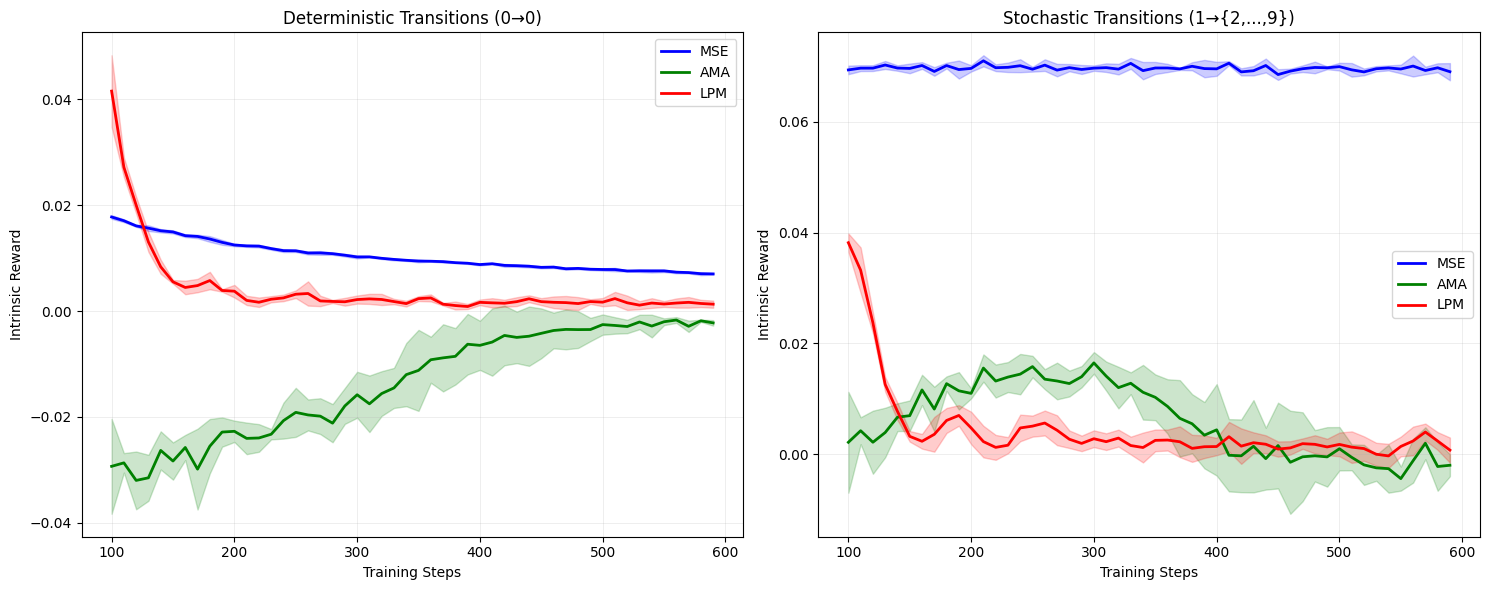

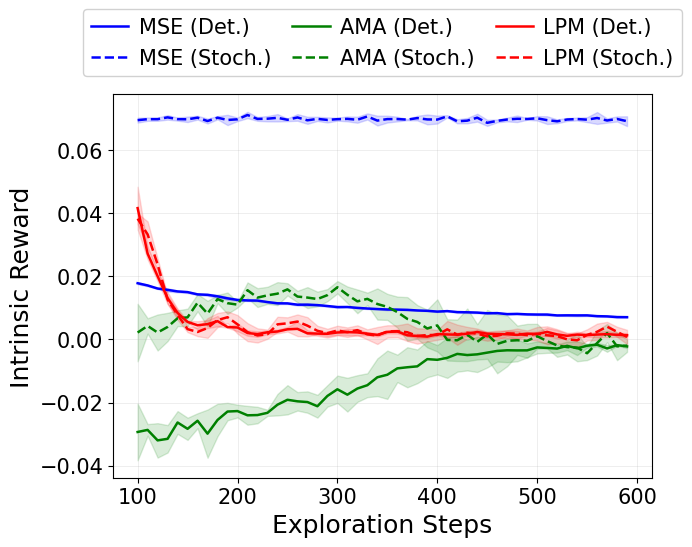


MULTI-RUN EXPERIMENT COMPLETED!
Results saved to: exploration_methods_comparison_5runs_results.npy
Plots saved to: exploration_methods_comparison_5runs.png and exploration_methods_combined_5runs.png

SUMMARY STATISTICS (Final Values, 5 runs):
--------------------------------------------------

MSE:
  Deterministic: 0.0070 ± 0.0001
  Stochastic: 0.0691 ± 0.0016

AMA:
  Deterministic: -0.0022 ± 0.0005
  Stochastic: -0.0020 ± 0.0020

LPM:
  Deterministic: 0.0013 ± 0.0007
  Stochastic: 0.0007 ± 0.0023


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mnist.loader import MNIST
from tqdm import tqdm
from collections import deque
import copy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST data
try:
    mndata = MNIST("data")
    x_train_data, y_train_data = mndata.load_training()
    x_test_data, y_test_data = mndata.load_testing()
    print("MNIST data loaded successfully")
except Exception as e:
    print(f"Error loading MNIST data: {e}")
    print("Make sure the 'mnist' package is installed and the data directory exists")
    print("You can install it with: pip install python-mnist")
    raise

# Define Noisy MNIST Environment
class NoisyMnistEnv:
    def __init__(self, split, input_number_min, input_number_max, batch_size=32, seed=0):
        self.seed = seed
        np.random.seed(seed)
        self.split = split
        if self.split == "train":
            self.x, self.y = x_train_data, y_train_data
        elif self.split == "test":
            self.x, self.y = x_test_data, y_test_data
        self.batch_size = batch_size
        self.input_number_min = input_number_min
        self.input_number_max = input_number_max

    def step(self):
        x_arr = np.zeros((self.batch_size, 28 * 28))
        y_arr = np.zeros((self.batch_size, 28 * 28))

        for i in range(self.batch_size):
            input_number = np.random.randint(self.input_number_min, self.input_number_max)
            if input_number == 0:
                output_number = 0
            if input_number == 1:
                output_number = np.random.randint(2, 10)
            input_data = self.get_random_sample_of_number(input_number)
            if input_number == 1:
                output_data = self.get_random_sample_of_number(output_number)
            elif input_number == 0:
                output_data = input_data
            x_arr[i] = np.array(input_data)
            y_arr[i] = np.array(output_data)
        return x_arr, y_arr

    def get_random_sample_of_number(self, number):
        random_num = np.random.randint(0, len(self.y) - 1)
        if self.y[random_num] == number:
            return self.x[random_num]
        else:
            return self.get_random_sample_of_number(number)

# Define MSE Network
class MSENet(nn.Module):
    def __init__(self):
        super(MSENet, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 784)
        self.linear_2 = nn.Linear(784, 784)
        self.linear_3 = nn.Linear(784, 784)
        self.linear_4 = nn.Linear(784 * 2, 28 * 28)

    def forward(self, input_x):
        x = F.relu(self.linear_1(input_x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = torch.cat((input_x, x), dim=1)
        x = self.linear_4(x)
        return x

# Define Aleatoric Network
class AleatoricNet(nn.Module):
    def __init__(self):
        super(AleatoricNet, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 784)
        self.linear_2 = nn.Linear(784, 784)
        self.linear_3_mu = nn.Linear(784, 784)
        self.linear_4_mu = nn.Linear(784 * 2, 28 * 28)
        self.linear_3_sigma = nn.Linear(784, 784)
        self.linear_4_sigma = nn.Linear(784, 28 * 28)

    def forward(self, input_x):
        x = F.relu(self.linear_1(input_x))
        x = F.relu(self.linear_2(x))
        mu = F.relu(self.linear_3_mu(x))
        mu = torch.cat((input_x, mu), dim=1)
        mu = self.linear_4_mu(mu)
        log_sigma = F.relu(self.linear_3_sigma(x))
        log_sigma = self.linear_4_sigma(log_sigma)
        return mu, log_sigma

# Define Uncertainty Predictor Network
class UncertaintyPredictor(nn.Module):
    def __init__(self):
        super(UncertaintyPredictor, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 256)
        self.linear_2 = nn.Linear(256, 128)
        self.linear_3 = nn.Linear(128, 64)
        self.linear_4 = nn.Linear(64, 28 * 28)

    def forward(self, input_x):
        x = F.relu(self.linear_1(input_x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        log_var = self.linear_4(x)
        return log_var

# Experience Buffer for uncertainty predictor
class ExperienceBuffer:
    def __init__(self, max_size=100):
        self.buffer = deque(maxlen=max_size)

    def add(self, input_data, error):
        self.buffer.append((input_data, error))

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            batch_size = len(self.buffer)
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        inputs = []
        errors = []
        for idx in indices:
            inp, err = self.buffer[idx]
            inputs.append(inp)
            errors.append(err)
        return torch.stack(inputs), torch.stack(errors)

    def __len__(self):
        return len(self.buffer)

# Base Experiment Class
class BaseExperiment:
    def __init__(self, training_steps, checkpoint_loss, lr, device, seed=42):
        self.training_steps = training_steps
        self.checkpoint_loss = checkpoint_loss
        self.lr = lr
        self.device = device
        self.seed = seed

        # Set random seeds for reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

        # Initialize environments with seed
        self.env_train = NoisyMnistEnv("train", 0, 2, batch_size=32, seed=seed)
        self.env_test_zeros = NoisyMnistEnv("test", 0, 1, batch_size=32, seed=seed+1000)
        self.env_test_ones = NoisyMnistEnv("test", 1, 2, batch_size=32, seed=seed+2000)

        self.reset_loss_buffers()

    def reset_loss_buffers(self):
        self.loss_list = []
        self.loss_buffer = []
        self.loss_list_0 = []
        self.loss_list_1 = []
        self.loss_buffer_0 = []
        self.loss_buffer_1 = []

    def preprocess_batch(self, data, target):
        data /= 255
        target /= 255
        return data, target

    def get_batch(self, env):
        data, target = env.step()
        data, target = self.preprocess_batch(data, target)
        data = torch.from_numpy(data).float().to(self.device)
        target = torch.from_numpy(target).float().to(self.device)
        return data, target

    def run_experiment(self):
        for update in tqdm(range(int(self.training_steps)), desc=f"Training {self.__class__.__name__} (seed={self.seed})"):
            self.train_step(update)
            self.eval_step("ones", update)
            self.eval_step("zeros", update)
        return self.loss_list_0, self.loss_list_1

# MSE Baseline Experiment
class MSEExperiment(BaseExperiment):
    def __init__(self, training_steps, checkpoint_loss, lr, device, seed=42):
        super().__init__(training_steps, checkpoint_loss, lr, device, seed)
        self.model = MSENet().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def compute_loss_and_reward(self, prediction, target):
        loss = F.mse_loss(prediction, target)
        reward = loss  # Intrinsic reward is the prediction error
        return loss, reward

    def train_step(self, update):
        update += 1
        self.model.train()
        data, target = self.get_batch(self.env_train)
        self.optimizer.zero_grad()
        output = self.model(data)
        loss, reward = self.compute_loss_and_reward(output, target)
        loss.backward()
        self.optimizer.step()
        self.loss_buffer.append(reward)
        if update % self.checkpoint_loss == 0:
            self.loss_list.append(
                torch.mean(torch.stack(self.loss_buffer)).detach().cpu().numpy()
            )
            self.loss_buffer = []

    def eval_step(self, ones_or_zeros, update):
        update += 1
        self.model.eval()
        if ones_or_zeros == "ones":
            env = self.env_test_ones
            loss_buffer = self.loss_buffer_1
            loss_list = self.loss_list_1
        elif ones_or_zeros == "zeros":
            env = self.env_test_zeros
            loss_buffer = self.loss_buffer_0
            loss_list = self.loss_list_0

        data, target = self.get_batch(env)
        with torch.no_grad():
            output = self.model(data)
            loss, reward = self.compute_loss_and_reward(output, target)
        loss_buffer.append(reward)

        if update % self.checkpoint_loss == 0:
            loss_list.append(
                torch.mean(torch.stack(loss_buffer)).detach().cpu().numpy()
            )
            loss_buffer.clear()

# AMA Experiment
class AMAExperiment(BaseExperiment):
    def __init__(self, training_steps, checkpoint_loss, lr, device, lambda_param=1.0, eta_param=1.0, seed=42):
        super().__init__(training_steps, checkpoint_loss, lr, device, seed)
        self.model = AleatoricNet().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.lambda_param = lambda_param
        self.eta_param = eta_param

    def compute_loss_and_reward(self, prediction, target):
        mu, log_sigma = prediction
        mse = F.mse_loss(mu, target, reduction="none")

        # Loss calculation using aleatoric uncertainty formula
        loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)

        # Intrinsic reward: MSE - η * exp(log_sigma)
        reward = torch.mean(mse - self.eta_param * torch.exp(log_sigma))

        return loss, reward

    def train_step(self, update):
        update += 1
        self.model.train()
        data, target = self.get_batch(self.env_train)
        self.optimizer.zero_grad()
        output = self.model(data)
        loss, reward = self.compute_loss_and_reward(output, target)
        loss.backward()
        self.optimizer.step()
        self.loss_buffer.append(reward)
        if update % self.checkpoint_loss == 0:
            self.loss_list.append(
                torch.mean(torch.stack(self.loss_buffer)).detach().cpu().numpy()
            )
            self.loss_buffer = []

    def eval_step(self, ones_or_zeros, update):
        update += 1
        self.model.eval()
        if ones_or_zeros == "ones":
            env = self.env_test_ones
            loss_buffer = self.loss_buffer_1
            loss_list = self.loss_list_1
        elif ones_or_zeros == "zeros":
            env = self.env_test_zeros
            loss_buffer = self.loss_buffer_0
            loss_list = self.loss_list_0

        data, target = self.get_batch(env)
        with torch.no_grad():
            output = self.model(data)
            loss, reward = self.compute_loss_and_reward(output, target)
        loss_buffer.append(reward)

        if update % self.checkpoint_loss == 0:
            loss_list.append(
                torch.mean(torch.stack(loss_buffer)).detach().cpu().numpy()
            )
            loss_buffer.clear()

# Uncertainty Predictor Experiment
class UncertaintyPredictorExperiment(BaseExperiment):
    def __init__(self, training_steps, checkpoint_loss, mse_lr, uncertainty_lr, device,
                 max_buffer_size=100, uncertainty_update_freq=10, uncertainty_batch_size=32, eta_param=1.0, seed=42):
        super().__init__(training_steps, checkpoint_loss, mse_lr, device, seed)
        self.mse_model = MSENet().to(device)
        self.uncertainty_model = UncertaintyPredictor().to(device)
        self.mse_optimizer = optim.Adam(self.mse_model.parameters(), lr=mse_lr)
        self.uncertainty_optimizer = optim.Adam(self.uncertainty_model.parameters(), lr=uncertainty_lr)
        self.experience_buffer = ExperienceBuffer(max_size=max_buffer_size)
        self.uncertainty_update_freq = uncertainty_update_freq
        self.uncertainty_batch_size = uncertainty_batch_size
        self.eta_param = eta_param

    def compute_mse_loss(self, prediction, target):
        return F.mse_loss(prediction, target, reduction='none')

    def update_uncertainty_model(self):
        if len(self.experience_buffer) < self.uncertainty_batch_size:
            return
        inputs, errors = self.experience_buffer.sample(self.uncertainty_batch_size)
        epsilon = 1e-6
        log_target = torch.log(errors + epsilon)
        log_variance = self.uncertainty_model(inputs)
        loss = F.mse_loss(log_variance, log_target)
        self.uncertainty_optimizer.zero_grad()
        loss.backward()
        self.uncertainty_optimizer.step()

    def compute_adjusted_reward(self, data, mse):
        with torch.no_grad():
            log_variance = self.uncertainty_model(data)
            variance = torch.exp(log_variance)
            adjusted_reward = - (mse - self.eta_param * variance) * 0.2
            per_sample_adjusted = adjusted_reward.mean()
        return per_sample_adjusted

    def train_step(self, update):
        update += 1
        self.mse_model.train()
        data, target = self.get_batch(self.env_train)
        self.mse_optimizer.zero_grad()
        prediction = self.mse_model(data)
        mse = self.compute_mse_loss(prediction, target)
        per_sample_mse = mse.mean(dim=1, keepdim=True).expand_as(mse)
        loss = mse.mean()
        loss.backward()
        self.mse_optimizer.step()

        # Store experience
        with torch.no_grad():
            for i in range(data.size(0)):
                self.experience_buffer.add(data[i].detach().clone(), per_sample_mse[i].detach().clone())

        # Update uncertainty model
        if update % self.uncertainty_update_freq == 0:
            self.update_uncertainty_model()

        # Compute adjusted reward for logging
        adjusted_reward = self.compute_adjusted_reward(data, mse)
        self.loss_buffer.append(adjusted_reward)

        if update % self.checkpoint_loss == 0:
            self.loss_list.append(
                torch.mean(torch.stack(self.loss_buffer)).cpu().numpy()
            )
            self.loss_buffer = []

    def eval_step(self, ones_or_zeros, update):
        update += 1
        self.mse_model.eval()
        if ones_or_zeros == "ones":
            env = self.env_test_ones
            loss_buffer = self.loss_buffer_1
            loss_list = self.loss_list_1
        elif ones_or_zeros == "zeros":
            env = self.env_test_zeros
            loss_buffer = self.loss_buffer_0
            loss_list = self.loss_list_0

        data, target = self.get_batch(env)
        with torch.no_grad():
            prediction = self.mse_model(data)
            mse = self.compute_mse_loss(prediction, target)
            adjusted_reward = self.compute_adjusted_reward(data, mse)

        loss_buffer.append(adjusted_reward)

        if update % self.checkpoint_loss == 0:
            loss_list.append(adjusted_reward.cpu().numpy())
            loss_buffer.clear()

def run_single_experiment(experiment_class, exp_params, run_id):
    """Run a single experiment with given parameters and run ID for seeding"""
    # Create a unique seed for this run
    seed = 42 + run_id * 1000

    if experiment_class == MSEExperiment:
        experiment = experiment_class(seed=seed, **exp_params)
    elif experiment_class == AMAExperiment:
        experiment = experiment_class(seed=seed, **exp_params)
    elif experiment_class == UncertaintyPredictorExperiment:
        experiment = experiment_class(seed=seed, **exp_params)

    return experiment.run_experiment()

def run_multiple_experiments_and_compare(
    num_runs=5,
    training_steps=600,
    checkpoint_loss=10,
    mse_lr=0.001,
    ama_lr=0.0001,
    uncertainty_mse_lr=0.001,
    uncertainty_lr=0.001,
    lambda_param=1.0,
    eta_param=1.0,
    max_buffer_size=100,
    uncertainty_update_freq=5,
    uncertainty_batch_size=32
):
    """
    Run all three experiments multiple times and plot comparative results with error bars
    """
    print("="*60)
    print(f"RUNNING COMPARATIVE EXPLORATION EXPERIMENTS ({num_runs} runs each)")
    print("="*60)

    # Define experiment parameters
    mse_params = {
        'training_steps': training_steps,
        'checkpoint_loss': checkpoint_loss,
        'lr': mse_lr,
        'device': device
    }

    ama_params = {
        'training_steps': training_steps,
        'checkpoint_loss': checkpoint_loss,
        'lr': 0.0001,
        'device': device,
        'lambda_param': lambda_param,
        'eta_param': eta_param
    }

    uncertainty_params = {
        'training_steps': training_steps,
        'checkpoint_loss': checkpoint_loss,
        'mse_lr': uncertainty_mse_lr,
        'uncertainty_lr': uncertainty_lr,
        'device': device,
        'max_buffer_size': max_buffer_size,
        'uncertainty_update_freq': uncertainty_update_freq,
        'uncertainty_batch_size': uncertainty_batch_size,
        'eta_param': eta_param
    }

    # Storage for results from all runs
    all_results = {
        'mse': {'det': [], 'stoch': []},
        'ama': {'det': [], 'stoch': []},
        'uncertainty': {'det': [], 'stoch': []}
    }

    # Run experiments multiple times
    for run_id in range(num_runs):
        print(f"\n--- Run {run_id + 1}/{num_runs} ---")

        # MSE Experiment
        print(f"Running MSE Baseline (Run {run_id + 1})...")
        mse_det, mse_stoch = run_single_experiment(MSEExperiment, mse_params, run_id)
        all_results['mse']['det'].append(mse_det)
        all_results['mse']['stoch'].append(mse_stoch)

        # AMA Experiment
        print(f"Running AMA (Run {run_id + 1})...")
        ama_det, ama_stoch = run_single_experiment(AMAExperiment, ama_params, run_id)
        all_results['ama']['det'].append(ama_det)
        all_results['ama']['stoch'].append(ama_stoch)

        # Uncertainty Predictor Experiment
        print(f"Running Uncertainty Predictor (Run {run_id + 1})...")
        up_det, up_stoch = run_single_experiment(UncertaintyPredictorExperiment, uncertainty_params, run_id)
        all_results['uncertainty']['det'].append(up_det)
        all_results['uncertainty']['stoch'].append(up_stoch)

    # Process results - find minimum length across all runs and methods
    min_length = float('inf')
    for method in all_results:
        for condition in ['det', 'stoch']:
            for run_data in all_results[method][condition]:
                min_length = min(min_length, len(run_data))

    print(f"\nProcessing results (minimum length: {min_length} points)...")

    # Truncate all results to minimum length and convert to numpy arrays
    processed_results = {}
    for method in all_results:
        processed_results[method] = {}
        for condition in ['det', 'stoch']:
            # Truncate each run to min_length and stack
            truncated_runs = [run_data[:min_length] for run_data in all_results[method][condition]]
            processed_results[method][condition] = np.array(truncated_runs)

    # Calculate means and standard deviations
    stats = {}
    for method in processed_results:
        stats[method] = {}
        for condition in ['det', 'stoch']:
            data = processed_results[method][condition]  # Shape: (num_runs, time_steps)
            stats[method][condition] = {
                'mean': np.mean(data, axis=0),
                'std': np.std(data, axis=0),
                'all_runs': data
            }

    # Generate steps for x-axis (skip first 10 points as in original)
    start_idx = 10
    steps = np.arange(start_idx * checkpoint_loss, min_length * checkpoint_loss, checkpoint_loss)

    # Plotting
    print(f"Creating plots (steps: {len(steps)}, skipping first {start_idx} data points)...")

    # Create comparison plots with error bars
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Colors and labels
    colors = {'mse': 'blue', 'ama': 'green', 'uncertainty': 'red'}
    labels = {'mse': 'MSE', 'ama': 'AMA', 'uncertainty': 'LPM'}

    # Plot deterministic transitions (0→0)
    for method in ['mse', 'ama', 'uncertainty']:
        mean_data = stats[method]['det']['mean'][start_idx:]
        std_data = stats[method]['det']['std'][start_idx:]
        ax1.plot(steps, mean_data, label=labels[method], color=colors[method], linewidth=2)
        ax1.fill_between(steps, mean_data - std_data, mean_data + std_data,
                        color=colors[method], alpha=0.2)

    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Intrinsic Reward')
    ax1.set_title('Deterministic Transitions (0→0)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot stochastic transitions (1→{2,...,9})
    for method in ['mse', 'ama', 'uncertainty']:
        mean_data = stats[method]['stoch']['mean'][start_idx:]
        std_data = stats[method]['stoch']['std'][start_idx:]
        ax2.plot(steps, mean_data, label=labels[method], color=colors[method], linewidth=2)
        ax2.fill_between(steps, mean_data - std_data, mean_data + std_data,
                        color=colors[method], alpha=0.2)

    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Intrinsic Reward')
    ax2.set_title('Stochastic Transitions (1→{2,...,9})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'exploration_methods_comparison_{num_runs}runs.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'Times', 'serif'],
        'mathtext.fontset': 'stix',
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
    })


    # Plot methods with distinguishable styles
    fig, ax = plt.subplots(figsize=(7, 5.2))

    # Plot methods with distinguishable styles
    line_styles = ['-', '--']
    line_labels = ['Det.', 'Stoch.']

    for method in ['mse', 'ama', 'uncertainty']:
        for i, env_type in enumerate(['det', 'stoch']):
            mean_data = stats[method][env_type]['mean'][start_idx:]
            std_data = stats[method][env_type]['std'][start_idx:]

            label = f'{labels[method]} ({line_labels[i]})'

            ax.plot(steps, mean_data,
                   label=label,
                   color=colors[method],
                   linestyle=line_styles[i],
                   linewidth=1.8)

            ax.fill_between(steps, mean_data - std_data, mean_data + std_data,
                           color=colors[method], alpha=0.15)

    # Labels with appropriate font sizes
    ax.set_xlabel('Exploration Steps', fontsize=18, fontweight='medium')
    ax.set_ylabel('Intrinsic Reward', fontsize=18, fontweight='medium')

    # Legend outside the plot area - optimized positioning
    ax.legend(fontsize=15, bbox_to_anchor=(0.5, 1.02), loc='lower center',
             ncol=3, frameon=True, fancybox=True, framealpha=0.9,
             columnspacing=1.0, handlelength=1.8, handletextpad=0.5)

    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Adjust layout to accommodate legend
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # More conservative than your original 0.85
    plt.savefig(f'exploration_methods_v1_{num_runs}runs.pdf',
                dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    # # Create combined plot
    # plt.figure(figsize=(20, 12))

    # # Plot all methods with different line styles for deterministic vs stochastic
    # for method in ['mse', 'ama', 'uncertainty']:
    #     # Deterministic
    #     mean_det = stats[method]['det']['mean'][start_idx:]
    #     std_det = stats[method]['det']['std'][start_idx:]
    #     plt.plot(steps, mean_det, label=f'{labels[method]} Deterministic',
    #             color=colors[method], linestyle='-', linewidth=2)
    #     plt.fill_between(steps, mean_det - std_det, mean_det + std_det,
    #                     color=colors[method], alpha=0.15)

    #     # Stochastic
    #     mean_stoch = stats[method]['stoch']['mean'][start_idx:]
    #     std_stoch = stats[method]['stoch']['std'][start_idx:]
    #     plt.plot(steps, mean_stoch, label=f'{labels[method]} Stochastic',
    #             color=colors[method], linestyle='--', linewidth=2)
    #     plt.fill_between(steps, mean_stoch - std_stoch, mean_stoch + std_stoch,
    #                     color=colors[method], alpha=0.15)

    # plt.xlabel('Exploration Steps', fontsize=47, fontweight='medium')
    # plt.ylabel('Intrinsic Reward', fontsize=47, fontweight='medium')

    # # Place legend outside the figure at the top
    # plt.legend(fontsize=40, bbox_to_anchor=(0.5, 1.04), loc='lower center', ncol=3)

    # plt.grid(True, alpha=0.3)
    # plt.xticks(fontsize=44, fontweight='medium')
    # plt.yticks(fontsize=44, fontweight='medium')

    # # Adjust layout to prevent legend cutoff
    # plt.tight_layout()
    # plt.subplots_adjust(top=0.85)

    # plt.savefig(f'exploration_methods_combined_{num_runs}runs.pdf', dpi=1000, bbox_inches='tight')
    # plt.show()

    # Save detailed results
    detailed_results = {
        'num_runs': num_runs,
        'steps_plotted': steps,
        'statistics': stats,
        'raw_results': all_results,
        'parameters': {
            'training_steps': training_steps,
            'checkpoint_loss': checkpoint_loss,
            'mse_lr': mse_lr,
            'ama_lr': ama_lr,
            'uncertainty_mse_lr': uncertainty_mse_lr,
            'uncertainty_lr': uncertainty_lr,
            'lambda_param': lambda_param,
            'eta_param': eta_param,
            'max_buffer_size': max_buffer_size,
            'uncertainty_update_freq': uncertainty_update_freq,
            'uncertainty_batch_size': uncertainty_batch_size
        }
    }

    np.save(f'exploration_methods_comparison_{num_runs}runs_results.npy', detailed_results)

    print("\n" + "="*60)
    print("MULTI-RUN EXPERIMENT COMPLETED!")
    print("="*60)
    print(f"Results saved to: exploration_methods_comparison_{num_runs}runs_results.npy")
    print(f"Plots saved to: exploration_methods_comparison_{num_runs}runs.png and exploration_methods_combined_{num_runs}runs.png")

    # Print summary statistics
    print(f"\nSUMMARY STATISTICS (Final Values, {num_runs} runs):")
    print("-" * 50)
    for method in ['mse', 'ama', 'uncertainty']:
        print(f"\n{labels[method]}:")
        for condition, condition_name in [('det', 'Deterministic'), ('stoch', 'Stochastic')]:
            final_mean = stats[method][condition]['mean'][-1]
            final_std = stats[method][condition]['std'][-1]
            print(f"  {condition_name}: {final_mean:.4f} ± {final_std:.4f}")

    return detailed_results

if __name__ == "__main__":
    # Set parameters
    num_runs = 5
    training_steps = 600
    checkpoint_loss = 10

    # Learning rates
    mse_lr = 0.001
    ama_lr = 0.001
    uncertainty_mse_lr = 0.001
    uncertainty_lr = 0.001

    # Model-specific parameters
    lambda_param = 1.0
    eta_param = 1.0

    # Uncertainty predictor specific parameters
    max_buffer_size = 100
    uncertainty_update_freq = 5
    uncertainty_batch_size = 32

    print(f"Starting comprehensive exploration methods comparison with {num_runs} runs...")

    results = run_multiple_experiments_and_compare(
        num_runs=num_runs,
        training_steps=training_steps,
        checkpoint_loss=checkpoint_loss,
        mse_lr=mse_lr,
        ama_lr=ama_lr,
        uncertainty_mse_lr=uncertainty_mse_lr,
        uncertainty_lr=uncertainty_lr,
        lambda_param=lambda_param,
        eta_param=eta_param,
        max_buffer_size=max_buffer_size,
        uncertainty_update_freq=uncertainty_update_freq,
        uncertainty_batch_size=uncertainty_batch_size
    )